In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
  inflating: METR-LA.h5              
  inflating: adj_METR-LA.pkl         


In [ ]:
!mkdir checkpoints

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# === Dataset === #
class METRLADataset(Dataset):
    def __init__(self, data, adj, exog=None, seq_len=12, pred_len=12):
        self.data = data
        self.adj = adj
        self.exog = exog
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_nodes = data.shape[0]
        self.num_timesteps = data.shape[1]

    def __len__(self):
        return self.num_timesteps - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        X = self.data[:, idx:idx+self.seq_len, :]
        Y = self.data[:, idx+self.seq_len:idx+self.seq_len+self.pred_len, 0]
        if self.exog is not None:
            U = self.exog[idx:idx+self.seq_len]
            U = np.repeat(U[np.newaxis, :, :], self.num_nodes, axis=0)
        else:
            U = np.zeros((self.num_nodes, self.seq_len, 0))
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(U, dtype=torch.float32),
            torch.tensor(Y, dtype=torch.float32),
        )

def load_adj(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

def create_time_exog(num_timesteps):
    hours = np.arange(num_timesteps) % 24
    return np.eye(24)[hours].astype(np.float32)

def load_metrla_dataframe(path):
    import pandas as pd
    df = pd.read_hdf(path)
    return df.values

def prepare_dataloaders(data_path, adj_path, batch_size=64, seq_len=12, pred_len=12):
    data = load_metrla_dataframe(data_path)
    data = data.T[:, :, None] if data.ndim == 2 else data
    adj = load_adj(adj_path)
    nodes, timesteps, features = data.shape

    scaler = StandardScaler()
    reshaped = data.reshape(nodes * timesteps, features)
    norm_data = scaler.fit_transform(reshaped).reshape(nodes, timesteps, features)
    exog = create_time_exog(timesteps)

    train_end = int(0.7 * timesteps)
    val_end = int(0.8 * timesteps)

    train_ds = METRLADataset(norm_data[:, :train_end, :], adj, exog[:train_end], seq_len, pred_len)
    val_ds   = METRLADataset(norm_data[:, train_end - seq_len - pred_len:val_end, :], adj, exog[train_end - seq_len - pred_len:val_end], seq_len, pred_len)
    test_ds  = METRLADataset(norm_data[:, val_end - seq_len - pred_len:, :], adj, exog[val_end - seq_len - pred_len:], seq_len, pred_len)

    def collate_fn(batch):
        X = torch.stack([b[0] for b in batch])
        U = torch.stack([b[1] for b in batch])
        Y = torch.stack([b[2] for b in batch])
        return X, U, Y

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn),
        scaler
    )

# === KalmanRNN === #
class KalmanRNN(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim) * 0.01)
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))
        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        B, N, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape
        YU = torch.cat([Y, U], dim=-1).reshape(B * N, T, obs_dim + exog_dim)
        h0 = torch.zeros(1, B * N, self.A.shape[0]).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(B, N, T, -1)
        h = torch.matmul(h, self.A.T)
        U_flat = U.view(B * N, T, exog_dim)
        U_applied = torch.matmul(U_flat, self.B.T).view(B, N, T, -1)
        return h + U_applied

# === Forecasting Head (multi-step) === #
class LSTMHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        B, N, T, F = h.shape
        h = h.view(B * N, T, F)
        _, (hn, _) = self.lstm(h)
        out = self.fc(hn[-1])
        return out.view(B, N, -1)

# === Train/Eval === #
def train(model, head, dataloader, optimizer, loss_fn, device):
    model.train()
    total = 0
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        optimizer.zero_grad()
        h = model(X, U)
        pred = head(h)
        loss = loss_fn(pred, Y)
        loss.backward()
        optimizer.step()
        total += loss.item()
        checkpoint_path = os.path.join("checkpoints", f"epoch_{epoch}.pt")
        torch.save(model.state_dict(), checkpoint_path)
    return total / len(dataloader)



@torch.no_grad()
def evaluate(model, head, dataloader, device):
    model.eval()
    errors = []
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        h = model(X, U)
        pred = head(h)
        mae = torch.mean(torch.abs(pred - Y))
        errors.append(mae.item())
    return sum(errors) / len(errors)

# === Main Runner === #
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader, _ = prepare_dataloaders(
        data_path="METR-LA.h5",
        adj_path="adj_METR-LA.pkl",
        batch_size=64,
        seq_len=12,
        pred_len=12
    )

    model = KalmanRNN(state_dim=64, obs_dim=1, exog_dim=24).to(device)
    head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(10):
        train_loss = train(model, head, train_loader, optimizer, loss_fn, device)
        val_mae = evaluate(model, head, val_loader, device)
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f}")

    test_mae = evaluate(model, head, test_loader, device)
    print(f"Final Test MAE: {test_mae:.4f}")

Epoch  0 | Train Loss: 0.3164 | Val MAE: 0.2705
Epoch  1 | Train Loss: 0.2733 | Val MAE: 0.2601
Epoch  2 | Train Loss: 0.2709 | Val MAE: 0.2685
Epoch  3 | Train Loss: 0.2707 | Val MAE: 0.2804
Epoch  4 | Train Loss: 0.2698 | Val MAE: 0.2780
Epoch  5 | Train Loss: 0.2706 | Val MAE: 0.2559
Epoch  6 | Train Loss: 0.2696 | Val MAE: 0.2774
Epoch  7 | Train Loss: 0.2683 | Val MAE: 0.2703
Epoch  8 | Train Loss: 0.2678 | Val MAE: 0.2769
Epoch  9 | Train Loss: 0.2672 | Val MAE: 0.2670
Final Test MAE: 0.2917


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_matrix_heatmap(matrix, title, save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix.cpu().detach().numpy(), cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.close()

def track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution"):
    os.makedirs(save_dir, exist_ok=True)
    for epoch, path in enumerate(model_checkpoints):
        state_dict = torch.load(path, map_location="cpu")
        A = state_dict.get("A") or state_dict.get("module.A")
        B = state_dict.get("B") or state_dict.get("module.B")
        C = state_dict.get("C") or state_dict.get("module.C")

        if A is not None:
            plot_matrix_heatmap(A, f"A Matrix - Epoch {epoch}", os.path.join(save_dir, f"A_epoch{epoch}.png"))
        if B is not None:
            plot_matrix_heatmap(B, f"B Matrix - Epoch {epoch}", os.path.join(save_dir, f"B_epoch{epoch}.png"))
        if C is not None:
            plot_matrix_heatmap(C, f"C Matrix - Epoch {epoch}", os.path.join(save_dir, f"C_epoch{epoch}.png"))

# Example usage:
# model_checkpoints = ["checkpoints/epoch_0.pt", "checkpoints/epoch_1.pt", ...]
# track_kalman_matrices(model_checkpoints)


In [ ]:
import os
import glob


# Automatically gather all checkpoint files from the directory and sort them
checkpoint_dir = "checkpoints"
model_checkpoints = sorted(
    glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")),
    key=lambda x: int(x.split("_")[-1].split(".")[0])  # extract epoch number
)
def track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution"):
    import os
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns

    os.makedirs(save_dir, exist_ok=True)

    def plot_matrix_heatmap(matrix, title, save_path=None):
        plt.figure(figsize=(6, 5))
        sns.heatmap(matrix.cpu().detach().numpy(), cmap="viridis", annot=False)
        plt.title(title)
        plt.xlabel("Columns")
        plt.ylabel("Rows")
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        plt.close()

    for epoch, path in enumerate(model_checkpoints):
        state_dict = torch.load(path, map_location="cpu")

        A = state_dict.get("A") if state_dict.get("A") is not None else state_dict.get("module.A")
        B = state_dict.get("B") if state_dict.get("B") is not None else state_dict.get("module.B")
        C = state_dict.get("C") if state_dict.get("C") is not None else state_dict.get("module.C")

        if A is not None:
            plot_matrix_heatmap(A, f"A Matrix - Epoch {epoch}", os.path.join(save_dir, f"A_epoch{epoch}.png"))
        if B is not None:
            plot_matrix_heatmap(B, f"B Matrix - Epoch {epoch}", os.path.join(save_dir, f"B_epoch{epoch}.png"))
        if C is not None:
            plot_matrix_heatmap(C, f"C Matrix - Epoch {epoch}", os.path.join(save_dir, f"C_epoch{epoch}.png"))

# Visualize learned matrices across epochs
track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution")


In [ ]:
def run_ablation(model, head, name):
    optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    best_val = float('inf')
    patience, early_stop = 0, 5
    train_losses, val_maes = [], []

    for epoch in range(10):
        loss = train(model, head, train_loader, optimizer, loss_fn, device)
        val_mae = evaluate(model, head, val_loader, device)
        train_losses.append(loss)
        val_maes.append(val_mae)
        if val_mae < best_val:
            best_val = val_mae
            patience = 0
        else:
            patience += 1
            if patience > early_stop:
                break
    test_mae = evaluate(model, head, test_loader, device)
    print(f"{name} Test MAE: {test_mae:.4f}")
    return train_losses, val_maes, test_mae

results = {}

# 1. Full KalmanRNN
model = KalmanRNN(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
results["KalmanRNN (Full)"] = run_ablation(model, head, "KalmanRNN (Full)")

# 2. KalmanRNN without learnable Kalman matrices (GRU only)
class KalmanRNN_wo_Kalman(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape
        YU = torch.cat([Y, U], dim=-1)  # (batch, nodes, T, obs_dim + exog_dim)
        YU = YU.view(batch * nodes, T, obs_dim + exog_dim)
        h0 = torch.zeros(1, batch * nodes, self.gru.hidden_size).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(batch, nodes, T, -1)
        return h


model = KalmanRNN_wo_Kalman(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
results["KalmanRNN w/o Kalman"] = run_ablation(model, head, "KalmanRNN w/o Kalman")

# 3. KalmanRNN without GRU (Kalman matrices only)
import torch.nn as nn

class KalmanRNN_wo_GRU(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim))
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim))
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        return Y.new_zeros(batch, nodes, T, 64)  # Dummy zero latent

model = KalmanRNN_wo_GRU(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
results["KalmanRNN w/o GRU"] = run_ablation(model, head, "KalmanRNN w/o GRU")

# 4. GRU-only baseline (no Kalman parameters at all)
from torch import nn

class GRUOnly(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, Y, U):
        X = torch.cat([Y, U], dim=-1)
        B, N, T, F = X.shape
        X = X.view(B * N, T, F)
        h0 = torch.zeros(1, B * N, self.gru.hidden_size).to(X.device)
        h, _ = self.gru(X, h0)
        return h.view(B, N, T, -1)

model = GRUOnly(input_dim=1+24, hidden_dim=64).to(device)
head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
results["GRU Only"] = run_ablation(model, head, "GRU Only")



KalmanRNN (Full) Test MAE: 0.3153
KalmanRNN w/o Kalman Test MAE: 0.2916
KalmanRNN w/o GRU Test MAE: 0.8197
GRU Only Test MAE: 0.2982


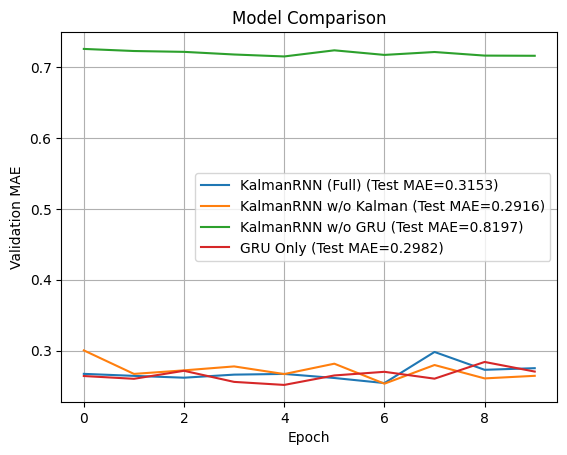

In [ ]:
def plot_metrics(results):
    for name, (losses, val_maes, test_mae) in results.items():
        plt.plot(val_maes, label=f"{name} (Test MAE={test_mae:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation MAE")
    plt.legend()
    plt.title("Model Comparison")
    plt.grid(True)
    plt.show()
plot_metrics(results)